In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

### The Sigmoid function

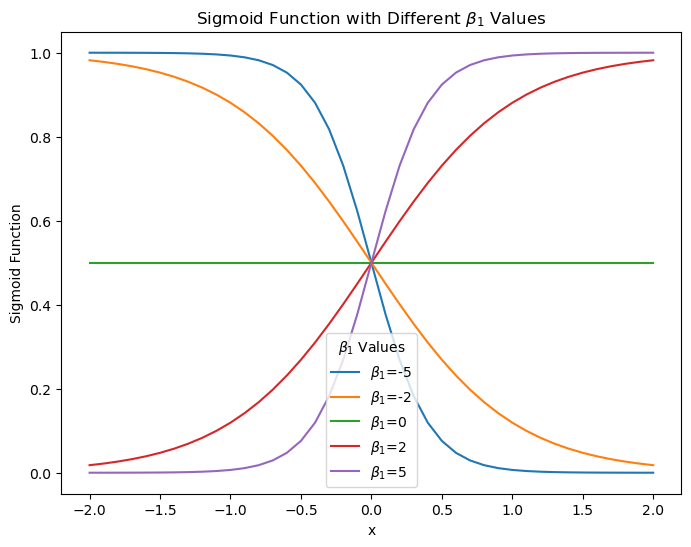

In [5]:
def logistic_func(x, beta_0, beta_1):
    return 1 / (1 + np.exp(-(beta_0 + beta_1 * x)))

# Let's fix beta_0 now, and see how the function changes with beta_1
betas_0 = [0]
betas_1 = [-5, -2, 0, 2, 5]

x_values = np.arange(-2, 2.1, 0.1)

# Create a DataFrame to store results
data = pd.DataFrame([(x, beta_0, beta_1, logistic_func(x, beta_0, beta_1))
                     for beta_0 in betas_0 for beta_1 in betas_1 for x in x_values],
                    columns=['x', 'beta_0', 'beta_1', 'y'])

plt.figure(figsize=(8, 6))
for beta_1 in betas_1:
    subset = data[data['beta_1'] == beta_1]
    plt.plot(subset['x'], subset['y'], label=f'$\\beta_1$={beta_1}')

plt.xlabel('x')
plt.ylabel('Sigmoid Function')
plt.title('Sigmoid Function with Different $\\beta_1$ Values')
plt.legend(title='$\\beta_1$ Values')
plt.show()


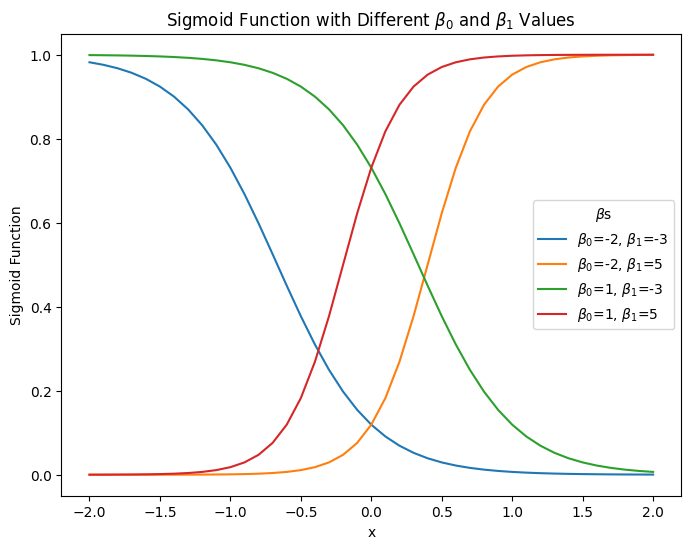

In [3]:
# Now do the same thing but vary both
betas_0 = [-2, 1]
betas_1 = [-3, 5]


data = pd.DataFrame([(x, beta_0, beta_1, logistic_func(x, beta_0, beta_1))
                     for beta_0 in betas_0 for beta_1 in betas_1 for x in x_values],
                    columns=['x', 'beta_0', 'beta_1', 'y'])


plt.figure(figsize=(8, 6))
for (beta_0, beta_1), subset in data.groupby(['beta_0', 'beta_1']):
    plt.plot(subset['x'], subset['y'], label=f'$\\beta_0$={beta_0}, $\\beta_1$={beta_1}')

plt.xlabel('x')
plt.ylabel('Sigmoid Function')
plt.title('Sigmoid Function with Different $\\beta_0$ and $\\beta_1$ Values')
plt.legend(title='$\\beta$s')
plt.show()

## Logistic Regression

In [6]:
#New Data set - UCI Wine data
wine = sklearn.datasets.load_wine()
print(wine.keys())
print(wine['DESCR'])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:          

In [7]:
wine_df = pd.DataFrame(np.concatenate((wine['target'].reshape(-1, 1), wine['data']), axis=1), 
    columns= ['target'] +  wine['feature_names'])
wine_df

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0.0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0.0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0.0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0.0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2.0,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,2.0,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,2.0,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,2.0,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [8]:
# The dataset has 3 classes, but let's use 2 for now
# And let's use just one predictor variable to make it easier to visualize
# Using sklearn
## NOTE: sklearn's deafult for LogisticRegression uses regularization (rdige) unless you specify it not to 

wine_filtered_df = wine_df[wine_df['target'] != 2]
X = wine_filtered_df['proline'].values.reshape(-1, 1)
y = wine_filtered_df['target'].values

model_1_feature = LogisticRegression(penalty=None)
model_1_feature.fit(X, y)

# Get predicted probabilities for the positive class
predicted_probs_1_feature = model_1_feature.predict_proba(X)[:, 1]

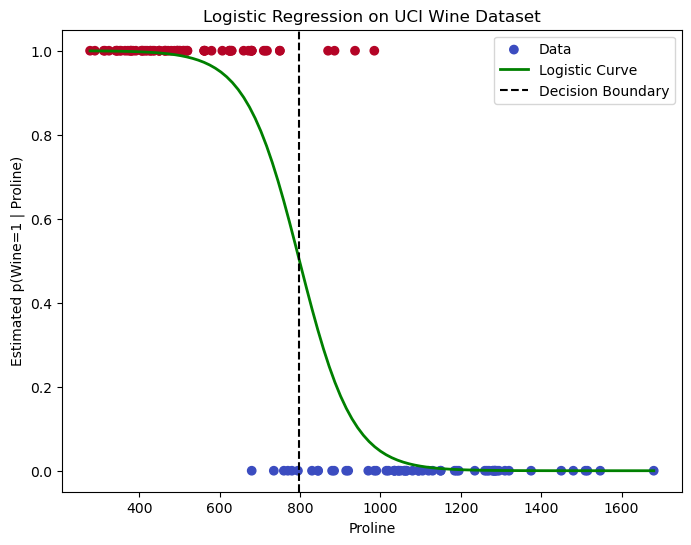

In [9]:
# Generate predictions on some new data to see the logistic curve
X_new = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
predicted_probs = model_1_feature.predict_proba(X_new)[:, 1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='coolwarm', label='Data')
plt.plot(X_new, predicted_probs, color='green', label='Logistic Curve', linewidth=2)
plt.axvline(-model_1_feature.intercept_[0] / model_1_feature.coef_[0][0], color='black', linestyle='dashed', label='Decision Boundary')
plt.xlabel('Proline')
plt.ylabel('Estimated p(Wine=1 | Proline)')
plt.title('Logistic Regression on UCI Wine Dataset')
plt.legend()
plt.show()


In [10]:
intercept = model_1_feature.intercept_[0]
coefficient = model_1_feature.coef_[0][0]

print(f'Intercept: {intercept:.4f}')
print(f'Coefficient for Proline: {coefficient:.4f}')

# Compute accuracy
accuracy = model_1_feature.score(X, y)
print(f'Model Accuracy: {accuracy:.4f}')

Intercept: 11.9751
Coefficient for Proline: -0.0150
Model Accuracy: 0.9231


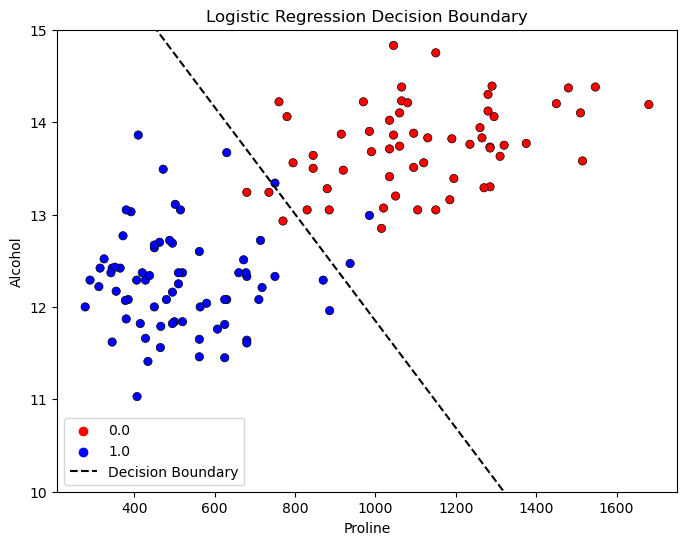

In [11]:
# Now let's use two predictors
X = wine_filtered_df[['proline', 'alcohol']].values
y = wine_filtered_df['target'].values

model_2_features = LogisticRegression()
model_2_features.fit(X, y)

intercept = model_2_features.intercept_[0]
coef_proline, coef_alcohol = model_2_features.coef_[0]

# Generate decision boundary line
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -(intercept + coef_proline * x_vals) / coef_alcohol

plt.figure(figsize=(8, 6))
sns.scatterplot(x=wine_filtered_df['proline'], y=wine_filtered_df['alcohol'], hue=wine_filtered_df['target'], palette=['red', 'blue'], edgecolor='k')
plt.plot(x_vals, y_vals, color='black', linestyle='dashed', label='Decision Boundary')
plt.xlabel('Proline')
plt.ylabel('Alcohol')
plt.ylim(10, 15)
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()


In [12]:
intercept = model_2_features.intercept_[0]
coefficient_0 = model_2_features.coef_[0][0]
coefficient_1 = model_2_features.coef_[0][1]

print(f'Intercept: {intercept:.4f}')
print(f'Coefficient for Proline: {coefficient_0:.4f}')
print(f'Coefficient for Alcohol: {coefficient_1:.4f}')

# Compute accuracy
accuracy = model_2_features.score(X, y)
print(f'Model Accuracy: {accuracy:.4f}')

Intercept: 36.5000
Coefficient for Proline: -0.0120
Coefficient for Alcohol: -2.0700
Model Accuracy: 0.9538


In [13]:
#Now using statsmodels

lmodel = sm.Logit(y, sm.add_constant(X)).fit()
print(lmodel.summary())

Optimization terminated successfully.
         Current function value: 0.075847
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  130
Model:                          Logit   Df Residuals:                      127
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.8899
Time:                        06:35:29   Log-Likelihood:                -9.8601
converged:                       True   LL-Null:                       -89.554
Covariance Type:            nonrobust   LLR p-value:                 2.450e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.0276     22.758      3.033      0.002      24.423     113.632
x1            -0.0137      0

## ROC Curves and AUC
The Receiver-operating characteristic curve (ROC) shows the tradeoff between the True Positive Rate (Sensitivity: probability of a positive result, conditioned on the example truly being positive) and False Positive Rate ($1 - \text{Specificity}$, where Specificity is defined as the probability of a negative result, conditioned on the sample truly being negative), at various classification thresholds. 

Area under the curve (AUC) is the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative. Visually this is the area under the ROC curve, which you can see below. A perfect classifier would have an AUC of 1.0 while a random classifier would have an AUC of 0.5 (shown by the dashed line below). Thus the higher the AUC, the better the model is at distinguishing between classes.

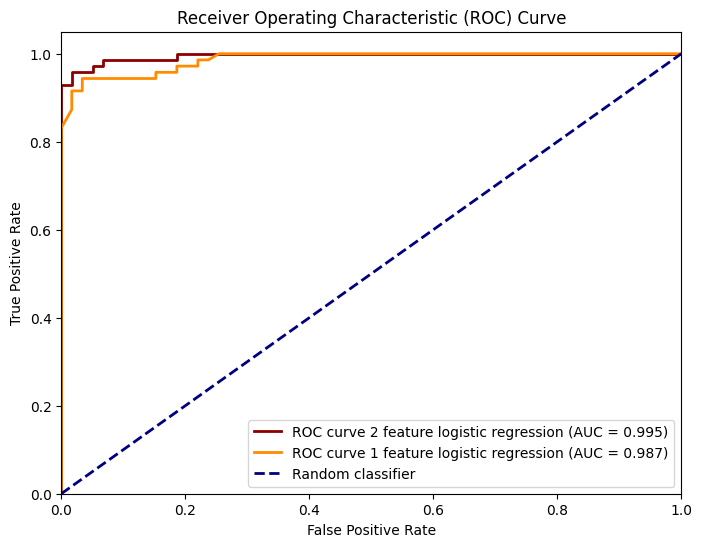

In [12]:
# Get predicted probabilities for the positive class
predicted_probs_2_features = model_2_features.predict_proba(X)[:, 1]

# Calculate ROC curves and AUCs
fpr, tpr, _ = roc_curve(y, predicted_probs_1_feature)
roc_auc = auc(fpr, tpr)
fpr_2, tpr_2, _ = roc_curve(y, predicted_probs_2_features)
roc_auc_2 = auc(fpr_2, tpr_2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_2, tpr_2, color='darkred', lw=2, label=f'ROC curve 2 feature logistic regression (AUC = {roc_auc_2:.3f})')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve 1 feature logistic regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


